# Toxic Comment Classification Challenge: Kaggle
[Link to the competition page](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

This is a classic text classification problem, where one is given a corpus of text documents with labelled classes, and one has to perform supervised machine learning to first train the data, and then classify unseen documents.

In [317]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import gensim
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [318]:
train = pd.read_csv('train.csv')

In [319]:
test = pd.read_csv('test.csv')

In [320]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [321]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


 - No missing values! How many times do you get that? All the non-toxic text is already labelled as 0.

### Distribution of hate comments

In [322]:
count_labels_ser = train.select_dtypes(include=np.number).sum(axis=0)
print(count_labels_ser)
#data.select_dtypes(include=np.number).isin([1]).any(axis=1).sum()
sum_toxic_comments = train.select_dtypes(include=np.number).apply(lambda row: any(row) == 1, axis=1).sum()
print('Total number of hate texts labelled = {}, out of {}'.format(sum_toxic_comments, train.shape[0]))

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64
Total number of hate texts labelled = 16225, out of 159571


Text(0, 0.5, '%age of occurence')

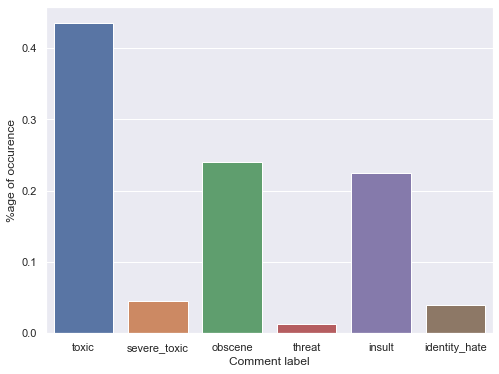

In [323]:
fig = plt.figure(figsize=(8,6))
sns.barplot(x=count_labels_ser.index,y=count_labels_ser/count_labels_ser.sum())
plt.xlabel('Comment label')
plt.ylabel('%age of occurence')

The data set is imbalanced, as you would expect. There are much fewer `severe_toxic` and `threat` comments than there are plain `toxic` ones.

- Next we will take a look at some random comments from each class of toxicity.

In [324]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for class_name in class_names:
    rand_text = np.random.choice(train[train[class_name]==1].index,size=1)[0] # Select a random comment from each class
    print('Example of {} text\n'.format(class_name), train.iloc[rand_text,1],'\n')

Example of toxic text
 Im sorry are you fucking stupid that nice person just gave me a warning then you fucking block me, nigger cunt eat pussy bitch 

Example of severe_toxic text
 FUCK YOU KID, Get the Fuck out of my country. 

Example of obscene text
 Subjectivity 

This user has a propensity to abuse his status by interfering with sourced articles. This user has proven to watch too much television leaving his personal life, and life skills comprimised. This user is a fan of big black cock. 

Example of threat text
 if you do not stop, the wikapidea nijas will come to your house and kill you 

Example of insult text
 Goodnightmush, I have two words for you go fuck your self. It you don't beleive what i'm writing; as I said: fuck you, fuck your mother fuck your sister fuck biggy fuck junior mafia and fuck your crew. 

Example of identity_hate text
 Dumb Niggaz 

Yall Niggas are dumb.Sean Kingston never played biggie.I was joking around dumbfucks. 



#### Lot of hate lurking there, beware!

- A particular comment can have multiple labels for 'toxicity'. For e.g.

In [325]:
train.iloc[6]

id                                           0002bcb3da6cb337
comment_text     COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
toxic                                                       1
severe_toxic                                                1
obscene                                                     1
threat                                                      0
insult                                                      1
identity_hate                                               0
Name: 6, dtype: object

In [326]:
from IPython.display import display, HTML
for col in train.columns[3:]:
    display(pd.crosstab(train['toxic'],train[col], margins=True))

severe_toxic,0,1,All
toxic,,,
0,144277,0,144277
1,13699,1595,15294
All,157976,1595,159571


obscene,0,1,All
toxic,,,
0,143754,523,144277
1,7368,7926,15294
All,151122,8449,159571


threat,0,1,All
toxic,,,
0,144248,29,144277
1,14845,449,15294
All,159093,478,159571


insult,0,1,All
toxic,,,
0,143744,533,144277
1,7950,7344,15294
All,151694,7877,159571


identity_hate,0,1,All
toxic,,,
0,144174,103,144277
1,13992,1302,15294
All,158166,1405,159571


In [327]:
train['len_comment'] = train['comment_text'].apply(len)
train.loc[train.iloc[:,2:8].sum(axis=1)>=1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,len_comment
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,44
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,319
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,57
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,648
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,40


mean character length of toxic comments: 295.24604420034
mean character length of clean comments: 404.5493391185012


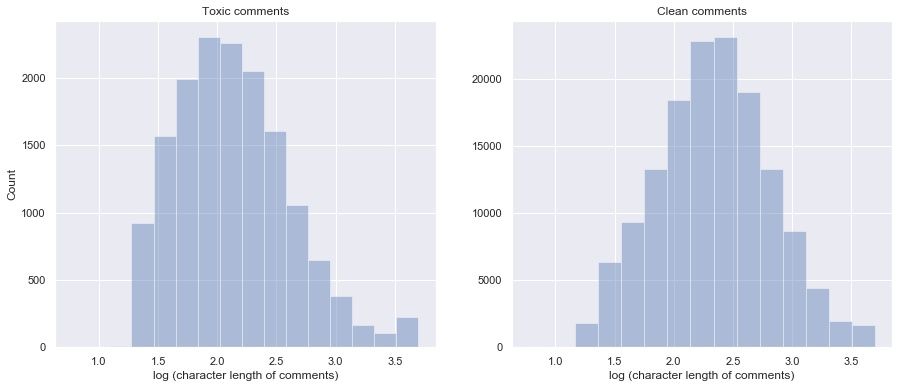

In [328]:
sns.set()
fig, ax = plt.subplots(1,2,sharex=True, figsize=(15,6))
_=sns.distplot(np.log10(train.loc[train.toxic==1,'len_comment']),kde=False, bins=15,ax=ax[0])
_=ax[0].set_xlabel('log (character length of comments)')
_=ax[0].set_ylabel('Count')
_=ax[0].set_title('Toxic comments')

_=sns.distplot(np.log10(train.loc[train.toxic==0,'len_comment']),kde=False, bins=15,ax=ax[1])
_=ax[1].set_xlabel('log (character length of comments)')
_=ax[1].set_title('Clean comments')
print('mean character length of toxic comments: {}'.format(train.loc[train.toxic==1,'len_comment'].mean()))
print('mean character length of clean comments: {}'.format(train.loc[train.toxic==0,'len_comment'].mean()))

#### The clean comments are longer than the toxic comments.

In [329]:
train_text = train['comment_text']
test_text = test['comment_text']

In [330]:
import string 
punctuation_set = set(string.punctuation)

In [331]:
def preprocess_comment(comment_str):
    '''
    This function preprocesses the comments and sets them up for vectorization.
    Input: comment string
    Returns: A string after converting the words to lowercase, removing punctuations, and lemmatizing each word
    '''
    stop_words = set(stopwords.words('english')) 
    lemmatizer = WordNetLemmatizer()
    comment=re.sub(r"(\d{1,3}\.){1,3}\d{1,3}","",comment_str)  #remove id's
    words = [word for word in word_tokenize(comment.lower()) if not word in stop_words]  # convert to lowercase and remove stopwords
    clean_words = [word for word in words if word not in punctuation_set] #remove puntuations
    lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word,pos='v') for word in clean_words if len(word)>2]) ## lemmatization
    return lemmatized_sentence             

In [332]:
print('Original text:\n {}'.format(train_text[2]))
print('After cleaning:\n {}'.format(preprocess_comment(train_text[1])))

Original text:
 Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
After cleaning:
 d'aww match background colour seemingly stick thank talk 21:51 january 2016 utc


In [333]:
train_text = train_text.apply(lambda comment: preprocess_comment(comment))

In [334]:
test_text = test_text.apply(lambda comment: preprocess_comment(comment))

In [335]:
full_text = pd.concat([train_text,test_text], axis=0)

In [142]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack

In [336]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
#    preprocessor= preprocess_comment,
    max_df = 0.7,
    ngram_range=(1, 2),
    max_features=40000)
word_vectorizer.fit(train_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.7, max_features=40000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='unicode',
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [337]:
import time
start = time.time()
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)
end = time.time()
print((end-start)/60,'mins')

0.38077911535898845 mins


In [343]:
print('Train matrix shape: {}'.format(train_word_features.shape))
print('Test matrix shape: {}'.format(test_word_features.shape))

Train matrix shape: (159571, 40000)
Test matrix shape: (153164, 40000)


In [344]:
feature_names = word_vectorizer.get_feature_names()

In [345]:
def top_tfidf_feats(row, features, top_n=10):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df
def top_feats_in_doc(X, features, row_id, top_n=10):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [346]:
rand_index = np.random.choice(range(len(train)), size=1)[0]
print(train.loc[rand_index, 'comment_text'])
top_feats_in_doc(train_word_features, feature_names, rand_index, top_n=5)

Doc Holliday Photo Problem

Yes, I know that that photo of the dark-haird man you used is on file in Denver as Doc Holliday. A different photo (see the collar) from the same photo session with the same man actually hangs in the Cochise County Courthouse in Tombstone, and is also labeled Holliday. But it isn't.

The only authentic closeup we have of Holliday is the one in Karen Tanner's book Doc Holliday: A Family Portrait. A standing picture we have of poor quality from 1879 shows he's still the same man by then (still light-haired, as Wyatt says). More importantly, the two closeups we have are of men with different ears.

See my note on the Doc Holliday discussion page. It behooves us to get a no-question photo of the real J. Holliday on Holliday's wiki page!  You can leave the other one in, but include a caption that due to the ears, some do not consider it authentic. You can then let the reader judge.


,feature,tfidf
0,doc,0.290522
1,photo,0.264449
2,ears,0.231911
3,authentic,0.225447
4,man,0.174260


In [347]:
def cross_val(clf,Xtrain=train_word_features, cv=3):
    scores = []
    class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    for class_name in class_names:
        train_target = train[class_name]
        cv_score = np.mean(cross_val_score(clf, Xtrain, train_target, cv=cv, scoring='roc_auc'))
        scores.append(cv_score)
        print('CV score for class {} is {}'.format(class_name, cv_score))
    print('Mean CV score is {}'.format(np.mean(scores)))

In [348]:
clf_NB = MultinomialNB(alpha=0.08)
clf_logreg = LogisticRegression(C=0.2, solver= 'sag')
print('--------Naive Bayes----------\n')
cross_val(clf_NB,cv=5)
print('--------Logistic Regression----------\n')
cross_val(clf_logreg)

--------Naive Bayes----------

CV score for class toxic is 0.950585183848843
CV score for class severe_toxic is 0.9761202649455388
CV score for class obscene is 0.9606174634049107
CV score for class threat is 0.9538698543951897
CV score for class insult is 0.9586982353597925
CV score for class identity_hate is 0.9537212028123869
Mean CV score is 0.9589353674611103
--------Logistic Regression----------

CV score for class toxic is 0.9630103410503662
CV score for class severe_toxic is 0.9841727515822555
CV score for class obscene is 0.982083246189514
CV score for class threat is 0.9767003026531652
CV score for class insult is 0.9724955189150948
CV score for class identity_hate is 0.9688126515582002
Mean CV score is 0.9745458019914327


In [369]:
import xgboost as xgb

In [ ]:
xgb_model = xgb.XGBClassifier(max_depth=5, n_estimators=300, n_jobs=-1,random_state=42)
cross_val(xgb_model)

In [ ]:
submission = pd.DataFrame.from_dict({'id': test['id']})
classifier = clf_logreg
for class_name in class_names:
    classifier.fit(train_word_features, train_target)
    submission[class_name] = classifier.predict_proba(test_word_features)[:, 1]
submission.to_csv('submission.csv', index=False)

## Topic modelling

In [155]:
tokenized_clean_train_text = [word_tokenize(doc) for doc in train_text]
gensim_dict = Dictionary(tokenized_clean_train_text)
gensim_dict.save('dictionary.dict')

/Users/debashis/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [156]:
len(gensim_dict)

233690

In [157]:
print(train_text[0])
gensim_dict.token2id['hardcore']

explanation edit make username hardcore metallica fan revert n't vandalisms closure gas vote new york dolls fac please n't remove template talk page since retire


7

In [146]:
corpus = [gensim_dict.doc2bow(doc) for doc in tokenized_clean_train_text]
gensim.corpora.MmCorpus.serialize('corpus.mm', corpus)

In [233]:
num_topics=10
lda = LdaModel(corpus, id2word=gensim_dict, num_topics=num_topics,iterations=5,eval_every=20)
lda.save('lda_10_topics.ldamodel')

/Users/debashis/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [232]:
lda.print_topics(num_words=5)

[(0,
  '0.034*"n\'t" + 0.015*"get" + 0.011*"know" + 0.011*"block" + 0.011*"make"'),
 (1,
  '0.011*"state" + 0.009*"name" + 0.009*"article" + 0.007*"english" + 0.007*"use"'),
 (2,
  '0.043*"use" + 0.031*"image" + 0.027*"list" + 0.021*"article" + 0.017*"link"'),
 (3,
  '0.018*"n\'t" + 0.016*"think" + 0.013*"know" + 0.011*"change" + 0.010*"one"'),
 (4,
  '0.016*"aid" + 0.009*"redirect" + 0.008*"game" + 0.006*"world" + 0.006*"talk"'),
 (5,
  '0.048*"fuck" + 0.032*"lol" + 0.019*"fat" + 0.018*"faggot" + 0.018*"suck"'),
 (6,
  '0.037*"source" + 0.012*"reference" + 0.010*"book" + 0.007*"reliable" + 0.007*"write"'),
 (7,
  '0.022*"article" + 0.015*"would" + 0.010*"make" + 0.010*"point" + 0.009*"think"'),
 (8,
  '0.058*"page" + 0.044*"wikipedia" + 0.039*"article" + 0.035*"edit" + 0.031*"please"'),
 (9,
  '0.037*"..." + 0.029*"utc" + 0.029*"http" + 0.014*"block" + 0.012*"vandalize"')]

In [351]:
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim

In [352]:
#lda = gensim.models.LdaModel.load('lda_10_topics.ldamodel')
#corpus = gensim.corpora.MmCorpus('corpus.mm')
#gensim_dict = gensim.corpora.Dictionary.load('dictionary.dict')

In [353]:
lda_display = pyLDAvis.gensim.prepare(lda, corpus, gensim_dict)

/Users/debashis/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [354]:
pyLDAvis.display(lda_display)

### Find the topic of a new document from the test set

In [278]:
newdoc = test_text[500]
print(newdoc)
new_doc_bow = gensim_dict.doc2bow(word_tokenize(preprocess_comment(newdoc)))

tomb unknown rapist discussion rule use content women east german wartime generation refer soviet war memorial treptower park berlin tomb unknown rapist response mass rap red army soldier years follow 1945 discussion establish art truth-telling authoritarian rule‎ page thing show locals refer tomb unknown rapist source anders thorsell locals city verification article know reference american vietnam war memorial inclusion reference pure dispute include include gross violation rise fall german democratic republic 1945-1990‎ page state east berlin treptow park painful memories reflect reference 'tomb unknown rapist'.12 *12 reference begin i.e know reference joke soviet period‎ page joke inappropriate encyclopaedia reference make mean capital city power memory monuments berlin state ... heavy weapons historically receive rather attention local population attract epithet tomb unknown rapist tomb ... one assume i.e engage original research refer monument berlin even one assume correctly talk

In [279]:
topic_proba_sorted = sorted(lda.get_document_topics(new_doc_bow),key = lambda row: row[1],reverse=True)
print(topic_proba_sorted)
ind_max_proba_topic = topic_proba_sorted[0][0]

[(1, 0.42033657), (9, 0.27511147), (0, 0.06970631), (2, 0.055821925), (7, 0.054950584), (4, 0.03437474), (6, 0.029902877), (8, 0.026670743), (5, 0.026072508)]


In [289]:
print('Topic words for the given document:\n {}'.format(', '.join([row[0] for row in lda.show_topic(ind_max_proba_topic)])))

Topic words for the given document:
 state, name, also, war, country, national, people, world, british, history


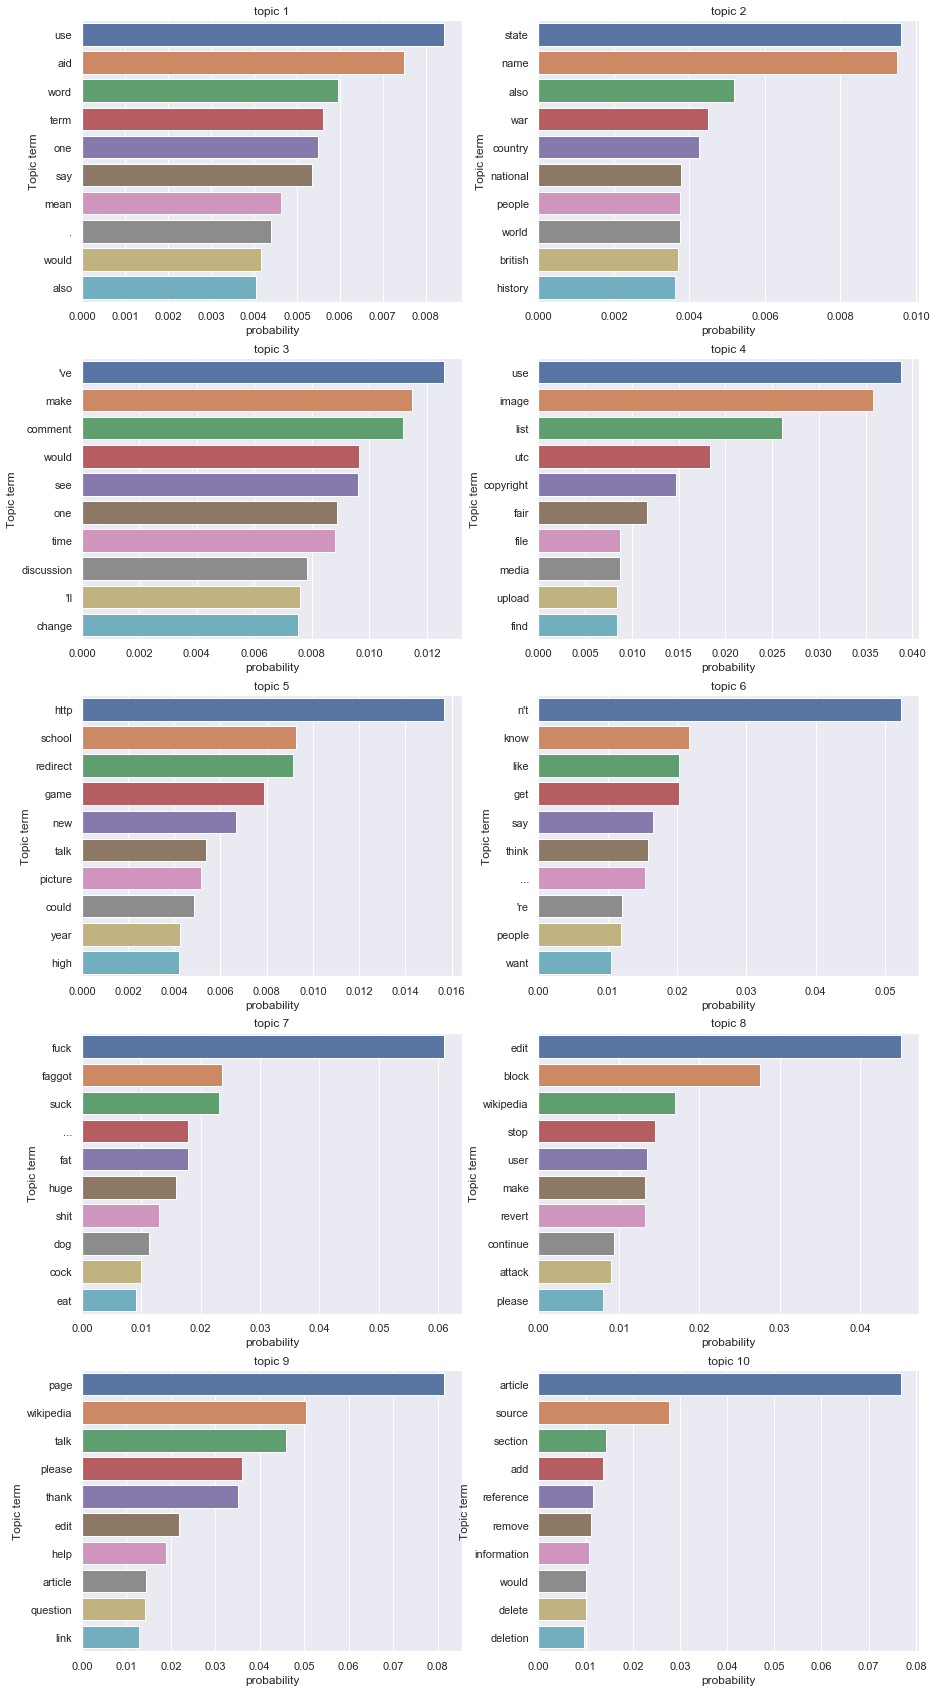

In [292]:
fig=plt.figure(figsize=(15,30))
for i in range(num_topics):
    df=pd.DataFrame(lda.show_topic(i), columns=['term','prob']).set_index('term')    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df)
    plt.xlabel('probability')
    plt.ylabel('Topic term')